# Proyecto Sweet Lift Taxi
---

- **Fecha:** 30-Abr-23
- **Notebook by:** Data Scientist Julio César Martínez Izaguirre
- **Senior Data Scientist:** by Alfonso Tobar

# Tabla de Contenido
---

1. Instrucciones del Proyecto
2. Descripción de los Datos
3. Preparación
4. Análsis de Procesos Estocástico
5. Formación de Modelos
6. Prueba
7. Conclusiones
8. Agradecimientos

# Licencia
---

Copyright @2023 by Julio César Martínez Izaguirre

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License

# Descripción del proyecto
---

La compañía **Sweet Lift Taxi** ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica **RECM** en el conjunto de prueba no debe ser superior a 48.

## || Instrucciones del proyecto.
---

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## || Descripción de los datos
---

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## || Preparación
---

Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import lightgbm
import sklearn
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from matplotlib import pyplot
from pylab import rcParams

# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

start_time = time.time()

print("Pandas Version:      ", pd.__version__)
print("Numpy Version :      ", np.__version__)
print("Seaborn Versión:     ", sns.__version__)
print("Scikit-Learn Version:", sklearn.__version__)
print("LightGBM Version:    ", lightgbm.__version__)

Pandas Version:       1.2.4
Numpy Version :       1.21.1
Seaborn Versión:      0.11.1
Scikit-Learn Version: 0.24.1
LightGBM Version:     3.3.1


Ahora vamos a importar nuestro **Dataframe** donde utilizaremos la transformación de datos de tipo **object** a tipo **datetime** durante la lectura del set y al mismo tiempo asignaremos las fechas al índice de la tabla.

In [2]:
sweetlift = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
# Vemos Dataframe
print("Tipo de columnas:       ", sweetlift.dtypes)
print("Tamaño del set de datos:", sweetlift.shape)
sweetlift.head()

Tipo de columnas:        datetime      datetime64[ns]
num_orders             int64
dtype: object
Tamaño del set de datos: (26496, 2)


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Información general.

In [4]:
sweetlift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


**OBSERVACIONES**

El dataframe de **Sweetlift** se compone de una columna y 26,496 filas. No se han detectado valores **nulos** o ausentes y al mismo tiempo se han ordenado los datos de acuerdo al tipo de **fecha y hora**. Además al importar los datos hemos convertido las columnas del tipo `objet` al tipo `datetime`.

## || Análisis de Proceso Estocástico

Vamos a realizar un poco de análisis estadístico con el objetivo de encontrar alguna inconsistencia en los datos y que al mismo tiempo ver qué otra información podemos obtener.

In [5]:
sweetlift.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
print("Fecha Inicio:", sweetlift.datetime.min())
print("Fecha Fin:   ", sweetlift.datetime.max())

Fecha Inicio: 2018-03-01 00:00:00
Fecha Fin:    2018-08-31 23:50:00


### Remuestreo

Ahora que sabemos cuál es el inicio y el final de nuestro set vamos a realizar un remuestreo, esto significa cambiar el intervalo con los valores de la serie. Vamos a realizar este procedimiento a través de la función **Resample** y agruparemos toda la información por horas debido a que este es el índicador que a **Sweetlift** más le interesa.

In [7]:
# Vamos a ordenar las fechas por hora
data = sweetlift.sort_index()
data = data.set_index('datetime').resample('H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


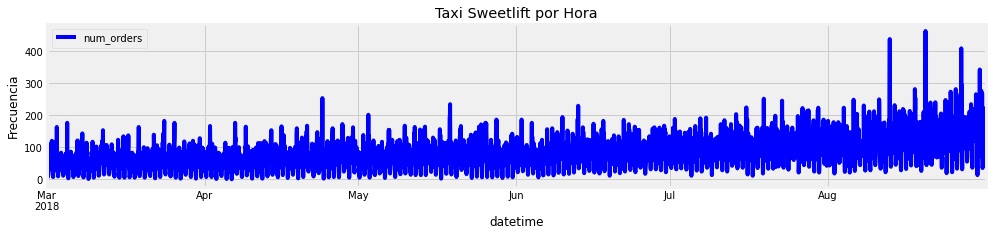

In [8]:
# Gráficamos la nueva tabla
data.plot(figsize=(15, 3),color = 'blue')
plt.title('Taxi Sweetlift por Hora')
plt.ylabel('Frecuencia')
plt.show()

### Media Móvil y Desviación Estándar

Ahora vamos a utilizar un método para suavizar los datos llamado **Media Móvil**, este método consiste en encontrar los valores menos suceptibles a fluctuaciones, es decir, la media aritmética. Para encontrar la media móvil utilizaremos la función `rolling` y enseguida especificarémos su tamaño.

                     num_orders       mean        std
datetime                                             
2018-03-01 00:00:00         124        NaN        NaN
2018-03-01 01:00:00          85        NaN        NaN
2018-03-01 02:00:00          71        NaN        NaN
2018-03-01 03:00:00          66        NaN        NaN
2018-03-01 04:00:00          43        NaN        NaN
2018-03-01 05:00:00           6        NaN        NaN
2018-03-01 06:00:00          12  58.142857  41.558908
2018-03-01 07:00:00          15  42.571429  32.118827
2018-03-01 08:00:00          34  35.285714  26.113306
2018-03-01 09:00:00          69  35.000000  25.664502


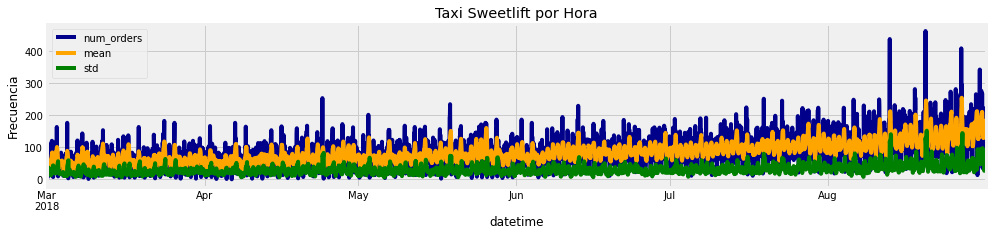

In [9]:
# Calcular media móvil y agregar nueva columna al dataset
data['mean'] = data['num_orders'].rolling(7).mean()
data['std']  = data['num_orders'].rolling(7).std()
print(data.head(10))

data.plot(figsize=(15, 3),color = ['darkblue','orange','green'])
plt.title('Taxi Sweetlift por Hora')
plt.ylabel('Frecuencia')
plt.show();

### Descomposición STL

Para comprender mejor nuestra serie temporal vamos analizar las tendencias y la estacionalidad. Recordemos que una **Tendencia** es un cambio ligero del valor medio de la serie sin repetir patrones. Por otro lado la **Estacionalidad** identifica patrones que se repiten de forma ciclica en una serie temporal. La tendencia y la estacionalidad dependen de la escala de los datos, es decir, no podemos ver patrones que se repiten todos los años si solo hay datos de un año. Para estudiar la tendencia y estacionalidad de nuestra serie temporal vamos a utilizar el módulo de `tsa.seasonal` de la librería `statsmodels` que contienen la función **seasonal_decompose()**.

Una serie temporal la podemos descomponer en tres partes:

- **Tendencia** ($T$): Trayectoria de los datos en el tiempo (dirección positiva o negativa).
- **Estacionalidad** ($S$): Fluctuaciones regulares y predecibles en un periodo determinado (anual, semestral, etc.)
- **Ruido** ($e$): error intrínsico al tomar una serie temporal (instrumentos, medición humana, etc.)

En muchas ocasiones no es posible descomponer el **proceso estocástico** puesto que la muestra obtenida no presenta un comportamiento ciclico o repetitivo en el periodo de tiempo analizado. Por otra parte esta descomposición puede realizarse de dos formas diferentes:

- **Aditiva**

$X_{t}=T_{t}+S_{t}+e_{t}$

- **Multiplicativa**

$X_{t}=T_{t} * S_{t} * e_{t}$

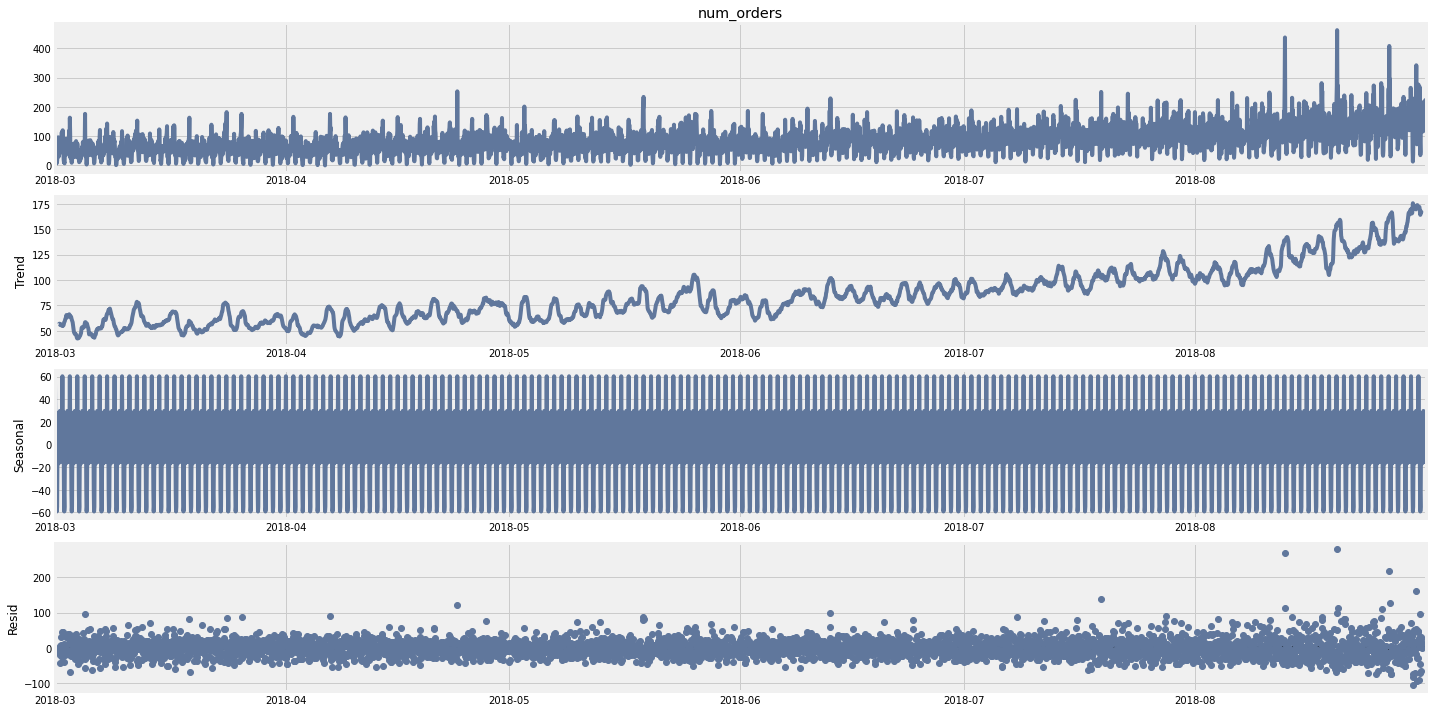

In [10]:
# Decomposición STL Forma A
#--------------------------
rcParams['figure.figsize'] = 20, 10
decomposition2 = sm.tsa.seasonal_decompose(data['num_orders'], model='aditive')
fig = decomposition2.plot()
plt.show()

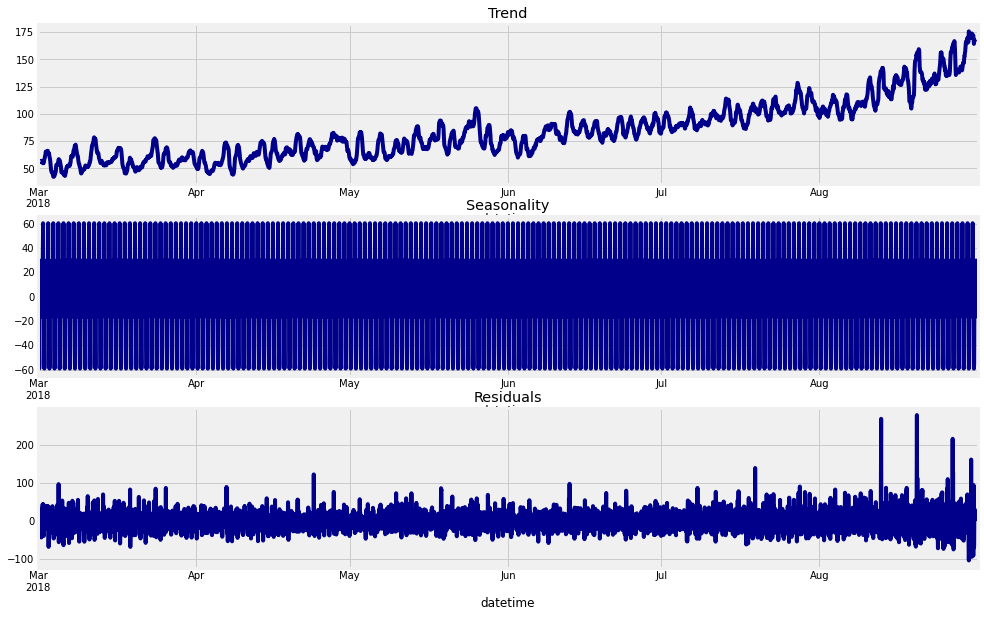

In [11]:
# Decomposición STL Forma B
#--------------------------
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especificamos su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca(),color = 'darkblue')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color = 'darkblue')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color = 'darkblue')
plt.title('Residuals')
plt.show();

Analicemos cada uno de estos gráficos:

- **gráfico 01** (serie original): este gráfico simplemente nos muestra la serie original graficada en el tiempo.
- **gráfico 02** (tendencia): este gráfico nos muestra la tendencia de la serie, para este caso, se tiene una tendencial lineal positiva.
- **gráfico 03** (estacionariedad): este gráfico nos muestra la estacionariedad de la serie, para este caso, se muestra una estacionariedad mensual, esta estacionariedad se puede ver como una forma estacionaria.
- **gráfico 04** (error): este gráfico nos muestra el error de la serie, para este caso, el error oscila entre -100 y 100. En general se busca que el error sea siempre lo más pequeño posible y que tenga el comportamiento de una distribución normal. Cuando el error sigue una distribución normal con media cero y varianza 1, se dice que el error es un **ruido blanco**.

**RUIDO BLANCO**

Veamos como es un ruido blanco.

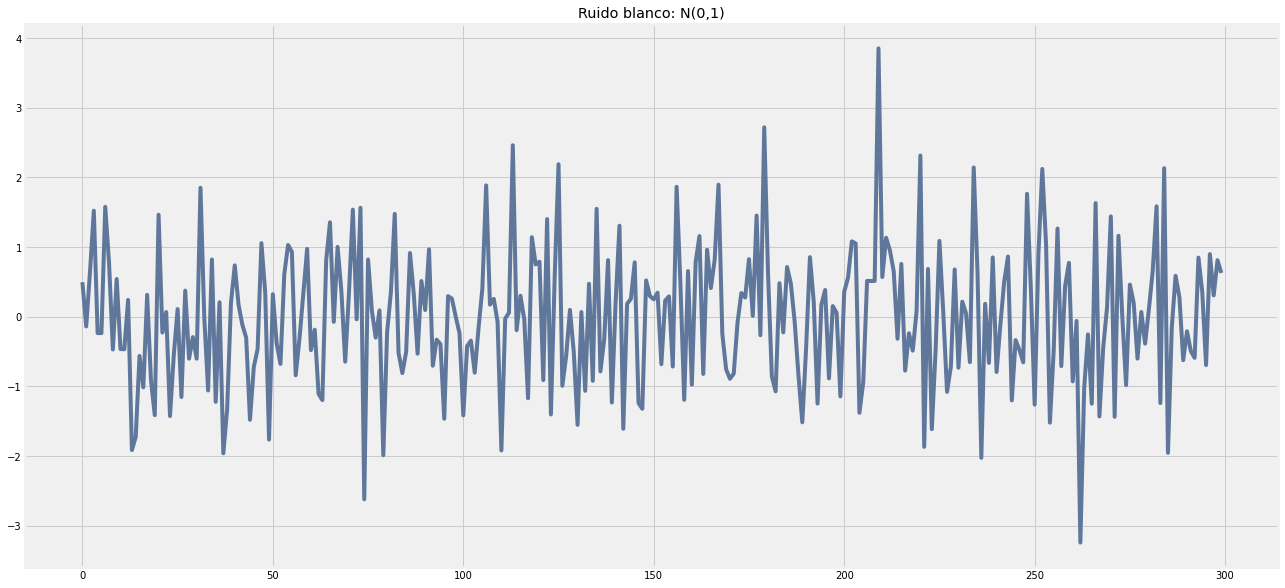

In [12]:
# Grafico: lineplot 
#------------------
np.random.seed(42) # fijar semilla

mean = 0
std = 1 
num_samples = 300


samples = np.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.title("Ruido blanco: N(0,1)")
plt.show()

Podemos ver que el ruido blanco oscila sobre el valor 0 y tiene una varianza constante (igual a 1). 

Ahora veamos el histograma de un ruido blanco.

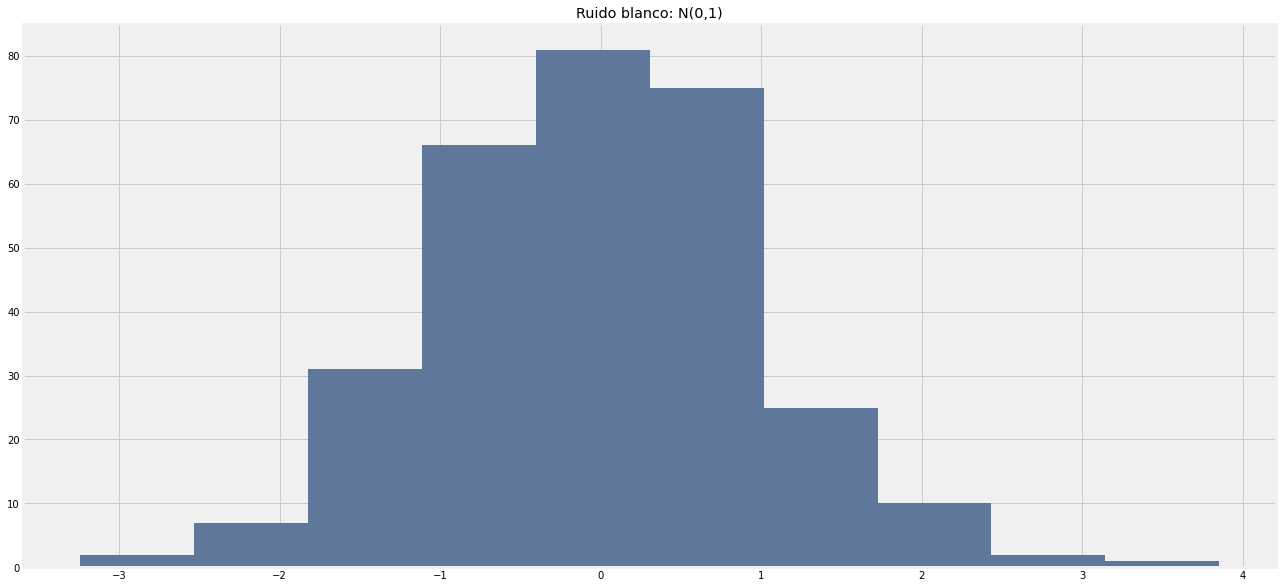

In [13]:
# Grafico: Histograma
#--------------------
plt.hist(samples,bins = 10)
plt.title("Ruido blanco: N(0,1)")
plt.show()

EL histograma de una variable normal, se caracteriza por esa forma de campana simétrica entorno a un valor, en este caso, entorno al valor 0.

### Serie Estacionaria

Como sabemos nuestro **Proceso Estocástico** se compone de una media y una varianza, y estos valores cambian. Se dice que nuestra serie es **Estacionaria** si su distribución no cambia con el tiempo, por el contrario si la distribución del proceso estocástico cambia entonces no es estacionaria. La manera más simple es gráficarla e inferir el comportamiento de esta. La ventaja que este método es rápido, sin embargo, se encuentra sesgado por el criterio del ojo humano. Por otro lado existen algunas alternativas que aquí presentamos:

**Autocorrelación (ACF) y autocorrelación parcial PACF**

Definamos a grandes rasgos estos conceptos:
- **Función de autocorrelación (ACF)**. En el retardo  𝑘 , es la autocorrelación entre los valores de las series que se encuentran a  𝑘  intervalos de distancia.
- **Función de autocorrelación parcial (PACF)**. En el retardo  𝑘 , es la autocorrelación entre los valores de las series que se encuentran a  𝑘 intervalos de distancia, teniendo en cuenta los valores de los intervalos intermedios.

Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una rápida disminución de la correlación después de un pequeño retraso entre los puntos.
Gráfiquemos la acf y pacf de nuestra serie temporal ocupando los comandos plot_acf y plot_pacf, respectivamente.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


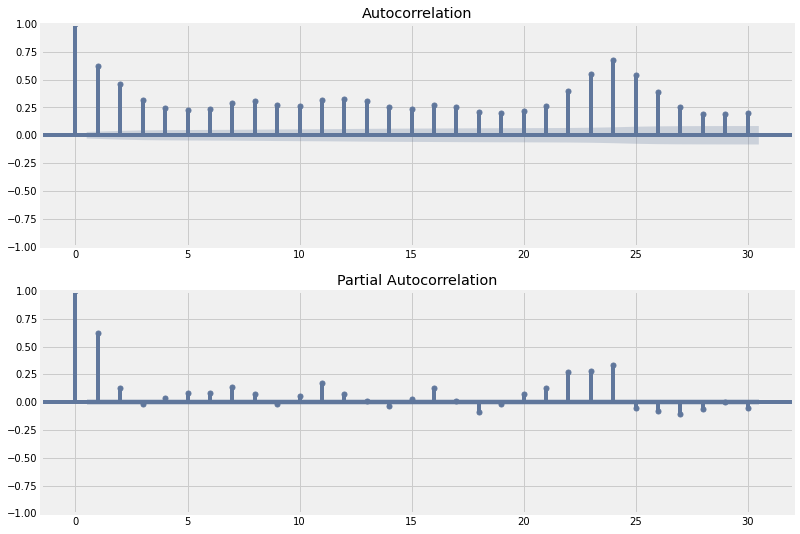

In [14]:
pyplot.figure(figsize=(12,9))

# ACF
#----
pyplot.subplot(211)
plot_acf(data['num_orders'], ax=pyplot.gca(), lags = 30)

#PACF
#----
pyplot.subplot(212)
plot_pacf(data['num_orders'], ax=pyplot.gca(), lags = 30)
pyplot.show()

Se observa de ambas imagenes, que estas decaen rápidamente a cero, por lo cual se puede decir que la serie en estudio es estacionaria.

**PRUEBA DE DICKEY-FULLER**

En estadística, la prueba Dickey-Fuller prueba la hipótesis nula de que una raíz unitaria está presente en un modelo autorregresivo. La hipótesis alternativa es diferente según la versión de la prueba utilizada, pero generalmente es estacionariedad o tendencia-estacionaria. Lleva el nombre de los estadísticos David Dickey y Wayne Fuller, quienes desarrollaron la prueba en 1979.

Para efectos práticos, para el caso de estacionariedad se puede definir el test como:
Hipótesis nula: la serie temporal no es estacionaria.
Hipótesis alternativa: la serie temporal es alternativa.
Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad

In [15]:
#Test Dickey-Fuller:
#-------------------
print ('Resultados del test de Dickey-Fuller:')
print ('------------------------------------------')
dftest = adfuller(data['num_orders'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Resultados del test de Dickey-Fuller:
------------------------------------------
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
dtype: float64


Dado que el **p-value** es 0.028940, se concluye que la serie temporal es estacionaria.

## || Formación
---

El objetivo del **Pronóstico de Series Temporales** es desarrollar un modelo que prediga los valores futuros de una serie temporal con base en datos anteriores. El periodo en el futuro para el que se prepara el pronóstico se conoce como **Horizonte de Pronóstico**. Si los valores de una serie temporal o de la función $X(t)$ (donde t = tiempo) son números, entonces nos enfrentamos a una tarea de regresión para la serie temporal, este es nuestro caso.

Comencemos escribiendo una función para crear características.

In [16]:
# Creamos Copia del Dataset
#--------------------------
df = data.copy()
df.drop(['mean', 'std'], axis=1, inplace=True)

In [17]:
# Función para Crear Características
#-----------------------------------
def make_features(data, max_lag, rolling_mean_size):
    # Agregar nuevas características
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Agregar y calcular nuevos valores de desfase
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    ## Agregar Media Móvil
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


# Aplicamos Función
#------------------
make_features(df, 3, 3)

In [18]:
# Comprobamos las características
df = df.dropna()
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,74.000000
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,60.000000
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,38.333333
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,20.333333


### Train Test Split

Vamos a dividir los datos en conjuntos de **Entrenamiento y Prueba** y a obtener las características de este último del conjunto de entrenamiento. Los valores restantes y la **Media Móvil** se pueden calcular a partir de datos anteriores. Las características de los primeros valores del conjunto de prueba se encuentran al final del conjunto de entrenamiento.

Es imposible obtener las características para los primeros valores del conjunto de entrenamiento porque no hay datos previos con los cuales trabajar. En los ejercicios anteriores, los valores de estos atributos fueron NaN. Estos se deben eliminar. Finalmente dejaremos como prueba el **10% de los datos** a petición de **Sweetlift**.

In [19]:
# Realizamos división de datos
#-----------------------------
train, test = train_test_split(df, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test  = test.drop(['num_orders'], axis=1)
y_test  = test['num_orders']

# Tamaño de los sets
#-------------------
print("Set de Entrenamiento:", X_train.shape, y_train.shape)
print("Set de Prueba:", X_test.shape, y_test.shape)
print()
# Comprobamos el orden correcto
#------------------------------
print("Fecha Inicial:", X_train.index.min(), "Fecha Final:", X_train.index.max())
print("Fecha Inicial:", X_test.index.min(), "Fecha Final", X_test.index.max())

Set de Entrenamiento: (3971, 8) (3971,)
Set de Prueba: (442, 8) (442,)

Fecha Inicial: 2018-03-01 03:00:00 Fecha Final: 2018-08-13 13:00:00
Fecha Inicial: 2018-08-13 14:00:00 Fecha Final 2018-08-31 23:00:00


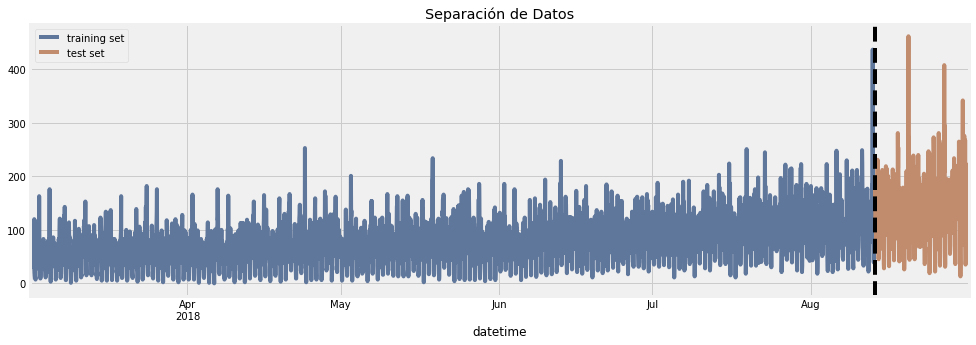

In [20]:
# Visualizamos el orden correcto
#-------------------------------
fig, ax = plt.subplots(figsize=(15,5))
y_train.plot(ax=ax)
y_test.plot(ax=ax)
ax.axvline('2018-08-13 14:00:00', color='black', ls='--')
plt.title('Separación de Datos')
plt.legend(['training set', 'test set'])
plt.show();

### Regresión Líneal

**TIME SERIES SPLIT**

In [21]:
# Definimos Time Series Split
#----------------------------
tscv = TimeSeriesSplit(n_splits=7)

preds  = []
scores = []

for i,(train_idx, test_idx) in enumerate(tscv.split(df)):
    train = df.iloc[train_idx]
    test  = df.iloc[test_idx] 
    
    features = ['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']
    target = 'num_orders'
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
        
    regresion_model = LinearRegression()
    regresion_model.fit(X_train, y_train)
    
    y_pred = regresion_model.predict(X_test)
    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred, squared=False)
    scores.append(score)
    print(f'score for fold {i}:', scores)

# Métrica Final
#--------------
RECM_lr = np.mean(scores)
print()
print('RECM Final:', RECM_lr)

score for fold 0: [25.514492864068522]
score for fold 1: [25.514492864068522, 29.181973467041665]
score for fold 2: [25.514492864068522, 29.181973467041665, 30.442374933817135]
score for fold 3: [25.514492864068522, 29.181973467041665, 30.442374933817135, 29.606511294045745]
score for fold 4: [25.514492864068522, 29.181973467041665, 30.442374933817135, 29.606511294045745, 31.674785749341126]
score for fold 5: [25.514492864068522, 29.181973467041665, 30.442374933817135, 29.606511294045745, 31.674785749341126, 37.18874877047696]
score for fold 6: [25.514492864068522, 29.181973467041665, 30.442374933817135, 29.606511294045745, 31.674785749341126, 37.18874877047696, 51.97139266260545]

RECM Final: 33.65432567734238


# Random Forest Regressor

Ahora probaremos el modelo del bosque aleatorio. Recordemos que Los árboles de decisión se utilizan tanto para problemas de regresión como de clasificación. Un **Bosque Aleatorio** se compone de muchos árboles de decisión. Fluyen visualmente como árboles, de ahí el nombre, y en el caso de regresión, comienzan con la raíz del árbol y siguen divisiones basadas en resultados variables hasta que se alcanza un nodo hoja y se da el resultado.

En el siguiente paso vamos a entrenar el modelo configurando un ajuste de hiperparámetros a través de la herramienta de **GridSearch** que viene incluída en la librería de **Scikit-Learn**. De esta manera podremos obtener los mejores resultados para nuestro modelo.

In [22]:
# Establecer valores para hiperparámetros
#-------------------------------------------
h_params = {'n_estimators' : [100, 200, 500],
            'max_depth' : [2, 4, 6], 
            'random_state' : [42]}

# Llamamos a GridSearchCV y colocamos los valores de los hiperparámetros
# La métrica RECM y el valor de validación cruzada
#-----------------------------------------------------------------------
gridSearch_rf = GridSearchCV(estimator = RandomForestRegressor(), 
                             param_grid = h_params, 
                             scoring = 'neg_root_mean_squared_error', 
                             cv=tscv)

In [23]:
# Entrenamiento de GridSearch
#----------------------------
start_tr = time.time()
gridSearch_rf.fit(X_train, y_train)
end_tr = time.time()

print(f"Tiempo de ajuste de hiperparámetros Random Forest: {end_tr-start_tr:.3f} seg")

Tiempo de ajuste de hiperparámetros Random Forest: 60.568 seg


In [24]:
# Buscar los mejores hiperparámetros que devolvió el valor más bajo de RECM
#--------------------------------------------------------------------------
max_score = gridSearch_rf.cv_results_['mean_test_score'].max()
index_max_score = np.where(gridSearch_rf.cv_results_['mean_test_score'] == max_score)[0][0]

best_set_params = gridSearch_rf.cv_results_['params'][index_max_score]

print(f"Mejores Hiperparámetros del Modelo: {best_set_params} | Mejor RECM: {-max_score:.3f}")

Mejores Hiperparámetros del Modelo: {'max_depth': 6, 'n_estimators': 100, 'random_state': 42} | Mejor RECM: 31.009


**ENTRENAMIENTO DEL MODELO**

In [25]:
# Entrenamiento del Modelo Random Forest
#----------------------------

start_tr_rf = time.time()
rf_model = RandomForestRegressor(max_depth=5, n_estimators=40, random_state=42)
rf_model.fit(X_train, y_train)
end_tr_rf = time.time()

# Calculamos las Predicciones
#----------------------------
start_ts_rf = time.time()
rf_predictions = rf_model.predict(X_test)
end_ts_rf = time.time()

# Establecemos el RECM
#----------------------------------------------------
RECM_rf = mean_squared_error(y_test, rf_predictions, squared=False)
print(f'RECM de Random Forest: {RECM_rf:.3f}')
print()
print(f'Tiempo de Entrenamiento: {end_tr_rf - start_tr_rf:.3f} seg')
print(f'Tiempo de Prueba: {end_ts_rf - start_ts_rf:.3f} seg')

RECM de Random Forest: 57.191

Tiempo de Entrenamiento: 0.270 seg
Tiempo de Prueba: 0.010 seg


### LightGBM Regressor

El método de potenciación de gradiente LightGBM utiliza árboles asimétricos y depende de los cálculos del árbol, por lo que divide la hoja del árbol con el mejor ajuste, de esta manera se produce una mayor precisión y disminuye los errores que pueden ocurrir al utilizar el cálculo por niveles. Al igual que Catboost, LightGBM puede procesar características categóricas, pero no utiliza One-Hot Encodig. Es necesario transformar las características a tipo entero, ya que no acepta variables de tipo string u objeto, también se puede optar por cambiar las características categoricas a tipo Category, que es lo que vamos a realizar a continuación para entrenar nuestro modelo.

**AJUSTE DE HIPERPARÁMETROS**

In [26]:
# Establecemos los hiperparámetros que vamos ajustar
#---------------------------------------------------
params_lightgbm = {'n_estimators' : [100, 500], 
                   'learning_rate': [0.1, 0.3],
                   'num_leaves'   : [31, 62],
                   'n_jobs'       : [-1]
                  }

# Llamamos al estimador que vamos a utilizar y
# Llamamos a GridSearchCV
#-------------------------------------------
lightgbm_est = LGBMRegressor()

gridSearch_lightgbm = GridSearchCV(
    estimator  = lightgbm_est,
    param_grid = params_lightgbm, 
    scoring    = 'neg_root_mean_squared_error',
    cv = tscv
)

# Entrenamos el Modelo en Búsqueda de los Hiperparámetros que lancen el mejor RECM
#---------------------------------------------------------------------------------
start_lgbm = time.time()
gridSearch_lightgbm.fit(X_train, y_train)
end_lgbm = time.time()
print(f'Tiempo de Entrenamiento: {end_lgbm-start_lgbm:.3f} seg')

Tiempo de Entrenamiento: 91.915 seg


In [27]:
# Buscamos los mejores Hipermarámetros del Modelo
#------------------------------------------------
max_score_lgbm = gridSearch_lightgbm.cv_results_['mean_test_score'].max()
index_max_score_lgbm = np.where(gridSearch_lightgbm.cv_results_['mean_test_score'] == max_score_lgbm)[0][0]

best_lgbm_set_params = gridSearch_lightgbm.cv_results_['params'][index_max_score_lgbm]

print(f"Mejores Hiperparámetros del Modelo: {best_lgbm_set_params} | Mejor RECM: {-max_score_lgbm:.3f}")

Mejores Hiperparámetros del Modelo: {'learning_rate': 0.1, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31} | Mejor RECM: 32.108


**ENTRENAMIENTO DEL MODELO**

In [28]:
# Aplicamos Validación Crizada Time Series Split
#-----------------------------------------------

# Entrenamos Modelo con los Mejores Hiperparámetros y
# Realizamos Predicciones en el Conjunto de Pruebas
#---------------------------------------------------
lightgbm_model   = LGBMRegressor(
    n_estimators = 100,
    learning_rate= 0.1,
    num_leaves   = 31,
    random_seed  = 42,
    n_jobs       = -1
)

start_ltr = time.time()
lightgbm_model.fit(X_train, y_train)
end_ltr = time.time()

start_lts = time.time()
lgbm_predictions = lightgbm_model.predict(X_test)
end_lts = time.time()

RECM_lightgbm = mean_squared_error(y_test, lgbm_predictions, squared=False)
print(f'RECM de LightGBM: {RECM_lightgbm:.3f}')
print()
print(f'Tiempo de Entrenamiento: {end_ltr-start_ltr:.3f} seg')
print(f'Tiempo de Prueba: {end_lts-start_lts:.3f} seg')

RECM de LightGBM: 55.748

Tiempo de Entrenamiento: 0.688 seg
Tiempo de Prueba: 0.004 seg


### XGBoost

XGBoost es un método de potenciación de gradiente que utiliza árboles asímetricos al igual que LightGBM, pero se diferencia en la forma como crecen sus árboles, los cuales crecen por niveles no por sus hojas por lo que se obtienen árboles más complejos y grandes que hace que el modelo tome más tiempo en realizar predicciones y entrenarse. Así mismo a diferencia de LightGBM y CatBoost, XGBoost no tiene su propia implementación para características categóricas y solo acepta características numéricas, por lo que requiere un preprocesamiento a través de One-Hot encoding para poder procesar datos categóricos. Por esta razón utilizaremos nuestro conjunto de entrenamiento, y prueba que ya fueron codificados a través de OHE para la Regresión Líneal.


**AJUSTE DE HIPERPARÁMETROS**

In [29]:
# Establecemos los hiperparámetros que vamos ajustar
#---------------------------------------------------
params_xgboost = {
    'booster'         : ['gbtree'],
    'max_depth'       : [6,12], 
    'n_estimators'    : [1500],
    'base_score'      : [0.5],
    'learning_rate'   : [0.01],
    'eval_metric'     : ['rmse'],
    'sampling_method' : ['uniform'],
    'subsample'       : [0.5],
    'n_jobs'          : [-1]
}

# Llamamos al estimador que vamos a utilizar y
# Llamamos a GridSearchCV
#-------------------------------------------
xgboost_est = XGBRegressor()

gridSearch_xgboost = GridSearchCV(
    estimator  = xgboost_est,
    param_grid = params_xgboost, 
    scoring    = 'neg_root_mean_squared_error',
    cv         = tscv,
    n_jobs     = -1
)

# Entrenamos el Modelo en Búsqueda de los Hiperparámetros que lancen el mejor RECM
#---------------------------------------------------------------------------------
start_xgb = time.time()
gridSearch_xgboost.fit(X_train, y_train)
end_xgb = time.time()
print(f'Tiempo de Entrenamiento: {end_xgb-start_xgb:.3f} seg')

Tiempo de Entrenamiento: 536.486 seg


In [30]:
# Buscamos los mejores Hipermarámetros del Modelo
#------------------------------------------------
max_score_xgb = gridSearch_xgboost.cv_results_['mean_test_score'].max()
index_max_score_xgb = np.where(gridSearch_xgboost.cv_results_['mean_test_score'] == max_score_xgb)[0][0]

best_xgb_set_params = gridSearch_xgboost.cv_results_['params'][index_max_score_xgb]

print(f"Mejores Hiperparámetros del Modelo: {best_xgb_set_params} | Mejor RECM: {-max_score_xgb:.3f}")

Mejores Hiperparámetros del Modelo: {'base_score': 0.5, 'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1500, 'n_jobs': -1, 'sampling_method': 'uniform', 'subsample': 0.5} | Mejor RECM: 32.171


**ENTRENAMIENTO DEL MODELO**

In [31]:
# Entrenamos Modelo con los Mejores Hiperparámetros y
# Realizamos Predicciones en el Conjunto de Pruebas
#---------------------------------------------------
xgboost_model = XGBRegressor(
    base_score = 0.5,
    booster      = 'gbtree',
    eval_metric  = 'rmse',
    learning_rate= 0.01,
    n_estimators = 1500,
    max_depth    = 6,
    n_jobs       = -1,
    sampling_method = 'uniform',
    subsample    = 0.5,
    random_state = 42
)

# Entrenamiento del Modelo
#-------------------------
start_tr_xgb = time.time()
xgboost_model.fit(X_train, y_train)
end_tr_xgb = time.time()

# Predicciones
#-------------
start_ts_xgb = time.time()
xgb_predictions = xgboost_model.predict(X_test)
end_ts_xgb = time.time()


## Metricas Finales
##-----------------
RECM_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
print(f'RECM de XGBoost: {RECM_xgb:.3f}')
print()
print(f'Tiempo de Entrenamiento: {end_tr_xgb-start_tr_xgb:.3f} seg')
print(f'Tiempo de Prueba: {end_ts_xgb-start_ts_xgb:.3f} seg')

RECM de XGBoost: 56.669

Tiempo de Entrenamiento: 35.236 seg
Tiempo de Prueba: 0.051 seg


## Prueba
---

### RECM

Una medida de uso frecuente de las diferencias entre los valores (valores de muestra o de población) predichos por un modelo o un estimador y los valores observados. La RECM representa la raíz cuadrada del segundo momento de la muestra de las diferencias entre los valores previstos y los valores observados o la media cuadrática de estas diferencias. Esta será la métrica base que utilizaremos para evaluar el rendimiento de nuestros modelos.

$$RECM = \sqrt ECM = \sqrt\frac{1}{n}\sum_{i=1}^{n} (\bar{y} - y)^2 $$

In [32]:
# Trazamos una Tabla con los Resultados del RECM obtenidos
#---------------------------------------------------------
models_table = pd.DataFrame({
    'modelo' : ['Regresión_Lineal', 'Random Forest', 'LightGBM', 'XGBoost'], 
    'RECM' : [RECM_lr, RECM_rf, RECM_lightgbm, RECM_xgb]
})

models_table.sort_values(by='RECM')

,modelo,RECM
0,Regresión_Lineal,33.654326
2,LightGBM,55.748355
3,XGBoost,56.669392
1,Random Forest,57.190704


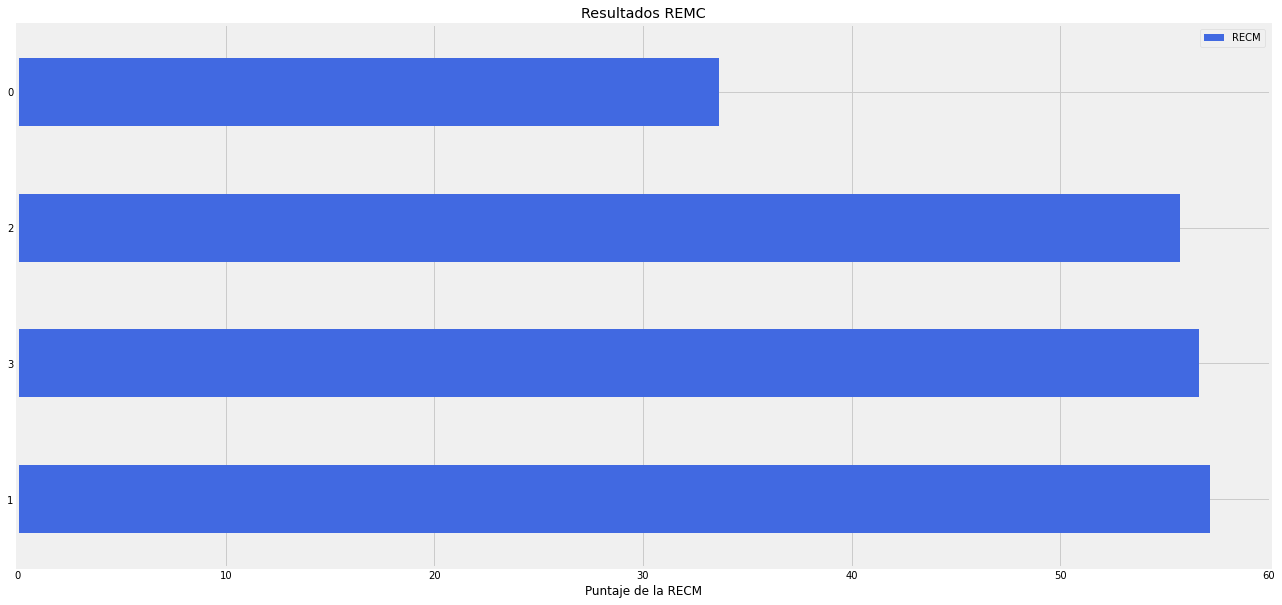

In [33]:
models_table.sort_values(by='RECM', ascending=False).plot(kind='barh', color='royalblue')
plt.title('Resultados REMC')
plt.xlabel('Puntaje de la RECM')
plt.show();

## || Conclusiones
---

Después de pasar un gran tiempo analizando este grandioso proyecto llegamos a las siguientes conclusiones:

1. Hemos preparado los datos e importado las librerías necesarias para el desarrollo del proyecto.
2. Se corrigió el tipo de datos de fechas que estaba en **Object** y se transformó a **Datetime**.
3. Se colocó la columna de tiempo en índice.
4. Realizamos un análsis de nuestra tabla donde hicimos el remuestreo de nuestra tabla, además estudiamos la **Desviación Estándar**, la **Media Móvil** y realizamos una **Descomposición STL**.
5. Se realizaron gráficas para visualizar esta investigación y se realizó una prueba de **Dickey-Fuller** para averiguar si la serie temporal era estacionaria o no.

**Entrenamiento de Modelos**

4. Se entrenaron cuatro modelos: **Linear Regresion, Random Forest, LightGBM, XGBoost**. Para cada modelo se ajustaron hiperparámetros con la implementación de **GridSearchCV** y la validación cruzada para series de tiempo llamada **TimeSeriesSplit**, basados en los resultados de los mejores hiperparámetros se entrenó cada modelo y se realizaron predicciones.
5. El modelo con mejores resultados fue la **Regresión Lineal** con una RECM de 33